# T3 CC6204 - Deep Learning


### **Por: Álvaro Morales Torres**

15-11-2023

Trabajado en local con CUDA y PyTorch

SPECS:

**CPU**: AMD Ryzen 7 5700XX (8 Core) @4.5 GHz.

**GPU**: NVIDIA GeForce RTX 3060 Ti (8GB VRAM).

16 GB RAM @ 3200 MHz.

En esta tarea van a crear una red neuronal que clasifique mensajes como spam o no spam. Lo primero es descargar la data:

In [1]:
!wget https://www.ivan-sipiran.com/downloads/spam.csv

--2023-11-15 08:07:36--  https://www.ivan-sipiran.com/downloads/spam.csv
Loaded CA certificate '/usr/ssl/certs/ca-bundle.crt'
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471781 (461K)
Saving to: 'spam.csv'

     0K .......... .......... .......... .......... .......... 10%  252K 2s
    50K .......... .......... .......... .......... .......... 21%  252K 1s
   100K .......... .......... .......... .......... .......... 32% 29.1M 1s
   150K .......... .......... .......... .......... .......... 43% 5.73M 1s
   200K .......... .......... .......... .......... .......... 54%  264K 1s
   250K .......... .......... .......... .......... .......... 65% 38.7M 0s
   300K .......... .......... .......... .......... .......... 75% 7.13M 0s
   350K .......... .......... .......... .......... .......... 86% 26.8M 0s
   400K ......

Los datos vienen en un archivo CSV que contiene dos columnas "text" y "label". La columna "text" contiene el texto del mensaje y la columna "label" contiene las etiquetas "ham" y "spam". Un mensaje "ham" es un mensaje que no se considera spam.

# Tarea
El objetivo de la tarea es crear una red neuronal que clasifique los datos entregados. Para lograr esto debes:



*   Implementar el pre-procesamiento de los datos que creas necesario.
*   Particionar los datos en 70% entrenamiento, 10% validación y 20% test.
*   Usa los datos de entrenamiento y valiadación para tus experimentos y sólo usa el conjunto de test para reportar el resultado final.

Para el diseño de la red neuronal puedes usar una red neuronal recurrente o una red basada en transformers. El objetivo de la tarea no es obtener el performance ultra máximo, sino entender qué decisiones de diseño afectan la solución de un problema como este. Lo que si es necesario (como siempre) es que discutas los resultados y decisiones realizadas.



In [606]:
# let's take a look at the data
import pandas as pd
df = pd.read_csv('spam.csv', encoding='utf-8', dtype=str, keep_default_na=False)
# keep_default_na=False to avoid pandas converting empty strings and numbers to NaN
df.head()


,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [607]:
# simple enough.
# how much data do we have?
print("Total rows: ", len(df))
# how many spam and ham?
print("Spam: ", len(df[df['label'] == "spam"]))
print("Ham: ", len(df[df['label'] == "ham"]))

# how long are the texts?
# average text length
print("Average text len: ", df['text'].map(lambda x: len(x)).mean())
# median text length
print("Median text len: ", df['text'].map(lambda x: len(x)).median())
# longest text length
print("Longest text len: ", df['text'].map(lambda x: len(x)).max())

Total rows:  5572
Spam:  746
Ham:  4617
Average text len:  78.42623833452978
Median text len:  59.0
Longest text len:  910


Parece que la mayoría de textos son cortos, mientras que la minoría son más largos. Tendré esto en mente al elegir el tamaño de la secuencia de entrada.

Diseñemos una RNN para resolver este problema.

## Parte 1: Pre-procesamiento de los datos

La idea es hacer esto a nivel de palabras. Por lo tanto necesitamos deshacernos de la puntuación y de las mayúsculas. Y por supuesto, dividir cada mensaje en palabras individuales.

In [608]:
from string import punctuation

# remove punctuation and set everything to lowercase
df['text'] = df['text'].map(lambda x: ''.join(c for c in x if c not in punctuation).lower())
df.head()

,text,label
0,go until jurong point crazy available only in ...,ham
1,ok lar joking wif u oni,ham
2,free entry in 2 a wkly comp to win fa cup fina...,spam
3,u dun say so early hor u c already then say,ham
4,nah i dont think he goes to usf he lives aroun...,ham


In [609]:
# now we get all the words
all_text = ' '.join(df['text'])
words = all_text.split()
print("Total words: ", len(words))
print(words[:100])

Total words:  83643
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat', 'ok', 'lar', 'joking', 'wif', 'u', 'oni', 'free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005', 'text', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'questionstd', 'txt', 'ratetcs', 'apply', '08452810075over18s', 'u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say', 'nah', 'i', 'dont', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though', 'freemsg', 'hey', 'there', 'darling', 'its', 'been', '3', 'weeks', 'now', 'and', 'no', 'word', 'back', 'id', 'like', 'some', 'fun', 'you', 'up', 'for', 'it', 'still']


Hay palabras medias raras y sin sentido, pero podrían ser representativas del spam.

## Parte 2: Codificar palabras y embedding de labels

Cada palabra es mapeada a un int.

In [610]:
from collections import Counter

# build word dictionary {word: frequency}
counts = Counter(words)
# sort words by frequency
vocab = sorted(counts, key=counts.get, reverse=True)
# dictionary to map words to integers
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
# turn each text into an array of integers
text_ints = []
for text in df['text']:
    text_ints.append([vocab_to_int[word] for word in text.split()])
print(df['text'][0:3])
print(text_ints[:3])
print("Unique words: ", len((vocab_to_int)))


0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
Name: text, dtype: object
[[45, 447, 4303, 786, 704, 670, 64, 8, 1230, 89, 119, 350, 1231, 152, 2851, 1232, 66, 56, 4304, 137], [48, 307, 1384, 431, 6, 1809], [47, 448, 8, 22, 4, 745, 891, 1, 179, 1810, 1126, 616, 1811, 2196, 261, 2197, 69, 1810, 1, 1812, 1, 308, 448, 2852, 78, 2853, 375, 2854]]
Unique words:  9396


Y para las etiquetas, digamos que 0 es ham y 1 es spam.

In [611]:
bin_labels = []
for label in df['label']:
    if label == "spam":
        bin_labels.append(1)
    else:
        bin_labels.append(0)
print(df['label'][0:3])
print(bin_labels[:3])

0     ham
1     ham
2    spam
Name: label, dtype: object
[0, 0, 1]


Ahora que tenemos los textos codificados, veamos si hay reviews de len 0 y cuál es el len promedio, mediano y máximo de secuecnias.

Estos datos nos ayudarán a tomar una decisión informada al elegir el tamaño de la secuencia de entrada.

In [612]:
lens = Counter([len(x) for x in text_ints])
print(f"Total texts: {len(text_ints)}")
print(f"0-len texts: {lens[0]}")
print(f"Average text len: {sum(lens.values()) / len(lens)}")
print(f"Median text len: {sorted(lens)[len(lens) // 2]}")
print(f"Maximum text len: {max(lens)}")

Total texts: 5572
0-len texts: 3
Average text len: 67.95121951219512
Median text len: 41
Maximum text len: 171


Vemos que en promedio las reviews tienen 69 palabras, la mediana es de 41, y el máximo es 171. parece haber una varianza bastante alta en el largo de las secuencias.

Idealmente, no queremos que la vasta mayoría de los features sean 0's. Por lo tanto, elegiremos un tamaño de secuencia de entrada de 50.

In [613]:
import numpy as np
# remove texts with 0 length
non_zero_idx = [ii for ii, text in enumerate(text_ints) if len(text) != 0]
text_ints = [text_ints[ii] for ii in non_zero_idx]
bin_labels = np.array([bin_labels[ii] for ii in non_zero_idx])
print(f"Total texts: {len(text_ints)}")

Total texts: 5569


## Parte 3: Padding

Definiendo `SEQ_LEN = 50`, hagamos padding de los textos para que todos tengan el mismo largo.

In [614]:
SEQ_LEN = 50

In [615]:
def pad_features(text_ints, seq_len = SEQ_LEN):
  features = np.zeros((len(text_ints), seq_len), dtype=int)

  #Para cada review, se coloca en la matriz
  for i, row in enumerate(text_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]
  
  return features

In [616]:
features = pad_features(text_ints)
print(features.shape)
print(features[:28,13:27])

(5569, 50)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0   47  448    8   22    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  840  116   66 1570   42  100  193  585   21]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0   72  222   13]
 [   0    0    0    0    0    0    0    0    0    0    0  672   72    4]
 [   0    0    0    0    0    0    0    0  129   13   92 1024  788   27]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0 1816 2861    1]
 [   0    0    0    0    0    0    0    0    0    0    0  194    3   17]
 [ 170  100 1572   12    5  144  521    

Puede que esto parezca demasiado padding, pero los resultados terminaron siendo bastante buenos (spoiler).

## Parte 4: Conujntos de entrenamiento, validación y test

Habíamos dicho 70% train, 10% val y 20% test.

In [617]:
TRAIN_RATIO = 0.7
TEST_VS_VAL_RATIO = 0.3334

# split the data. training set = 70%, validation set = 10%, test set = 20%
split_idx = int(len(features)*TRAIN_RATIO)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = bin_labels[:split_idx], bin_labels[split_idx:]

test_idx = int(len(remaining_x)*TEST_VS_VAL_RATIO)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

assert train_x.shape[0] + val_x.shape[0] + test_x.shape[0] == features.shape[0], "Something went wrong with the split"

print("\t\t\tFeatures:\t%'s:")
print("Train set: \t\t{} \t{:.2f}".format(train_x.shape, 100*train_x.shape[0]/features.shape[0]),
      "\nValidation set: \t{} \t{:.2f}".format(val_x.shape, 100*val_x.shape[0]/features.shape[0]),
      "\nTest set: \t\t{} \t{:.2f}".format(test_x.shape, 100*test_x.shape[0]/features.shape[0]))

			Features:	%'s:
Train set: 		(3898, 50) 	69.99 
Validation set: 	(557, 50) 	10.00 
Test set: 		(1114, 50) 	20.00


Idealmente queremos que la cantidad de elementos en train sean divisibles por el batch_size (en caso de que no lo sea, podemos pasarle el parámetro `drop_last=True` al DataLoader, pero esto no es ideal porque se ignorarían los datos restantes).

Desafortunadamente, 3898 solo es divisible 1, 2, 1949 y 3898. Por lo que habrá que ocupar `drop_last=True` y escoger un batch_size tal que no ignoremos muchos datos.

3898 es muy cercano a 3900, que es divisible por 50. Por lo tanto el batch_size será 50.

## Parte 5: Creación del modelo

Usaremos una RNN igual a la que se usó en el Lab 11. Es decir con:
- Una capa de embedding que convierte los tokens (palabras) a vectores de cierto tamaño (parámetro)
- Una capa LTSM definida por el tamaño del estado oculto y el número de capas (parámetros)
- Una capa de salida FC que mapea la salida del LSTM a una salida de cierto tamaño (parámetro)
- Una capa de activación sigmoide con salida 0 o 1.

In [628]:
# rng dependent stuff starts here:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
SEED = 6669 # lml and nice

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Hacemos nuestros data loaders. Como se dijo antes, el batch_size será 50, y necesitamos drop_last=True porque nuestro conjunto de train no es exactamente divisible por 50.

In [629]:
# create Datasets and DataLoaders
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
BATCH_SIZE = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

In [630]:
# check if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


Definición del modelo, como fue descrito anteriormente:

In [631]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden) 
        # take the last output of the LSTM
        lstm_out = lstm_out[:,-1,:]    
        # dropout and fully-connected
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid
        sig_out = self.sig(out)
        # return sigmoid and the last hidden state
        return sig_out, hidden
    
    def init_hidden(self, batch_size=BATCH_SIZE):
        # create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        if(train_on_gpu):
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

Instanciamiento (seteo de los parámetros mencionados):

In [632]:
# Instanciate the RNN
vocab_size = len(vocab_to_int) + 1 # +1 for zero padding + our word tokens
output_size = 1 # binary classification
embedding_dim = 50 # word embedding dimension
hidden_dim = 256 # hidden dimension
n_layers = 2 # number of LSTM layers

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(9397, 50)
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Parte 6: Training

A entrenar el modelo. Un learning rate de 0.001 fue suficientemente bueno.

Por otro lado, Cross Entropy Loss es ideal para clasificación binaria, y Adam es un excelente optimizador para este problema.

También usaremos gradient clipping para evitar gradientes muy grandes.

In [633]:
LEARNING_RATE = 0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

Después de algunos intentos con varios números de epochs, el loss de validación dejó de decrecer a los 4 o 5 epochs, y para valores más grandes de epoch empezó a aumentar hasta overfittear.

5 epochs parece ser un buen valor.

In [634]:
# arrays for plotting
train_losses_for_plot = []
val_losses_for_plot = []
steps_for_plot = []
# training params
EPOCHS = 5
counter = 0
print_every = 50
clip = 5 # gradient clipping
# move model to GPU, if available
if(train_on_gpu):
    net.cuda()
net.train()
# train for some number of epochs
for e in range(EPOCHS):
    # initialize hidden state
    h = net.init_hidden(BATCH_SIZE)
    # batch loop
    for inputs, labels in train_loader:
        counter += 1
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        # Create new vars for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        net.zero_grad()
        # forward pass
        output, h = net(inputs, h)
        # calculate loss
        loss = criterion(output.squeeze(), labels.float())
        # backward pass
        loss.backward()
        # gradient clipping
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        # messages
        if counter % print_every == 0:
            # validation loss
            val_h = net.init_hidden(BATCH_SIZE)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])
                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())
            net.train()
            # append losses to plotting arrays
            train_losses_for_plot.append(loss.item())
            val_losses_for_plot.append(np.mean(val_losses))
            steps_for_plot.append(counter)
            print("Epoch: {}/{}...".format(e+1, EPOCHS),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses))
            )

Epoch: 1/5... Step: 50... Loss: 0.118664... Val Loss: 0.218780
Epoch: 2/5... Step: 100... Loss: 0.158365... Val Loss: 0.180397
Epoch: 2/5... Step: 150... Loss: 0.080311... Val Loss: 0.146888
Epoch: 3/5... Step: 200... Loss: 0.082398... Val Loss: 0.116931
Epoch: 4/5... Step: 250... Loss: 0.092349... Val Loss: 0.110323
Epoch: 4/5... Step: 300... Loss: 0.006044... Val Loss: 0.123274
Epoch: 5/5... Step: 350... Loss: 0.014892... Val Loss: 0.091375


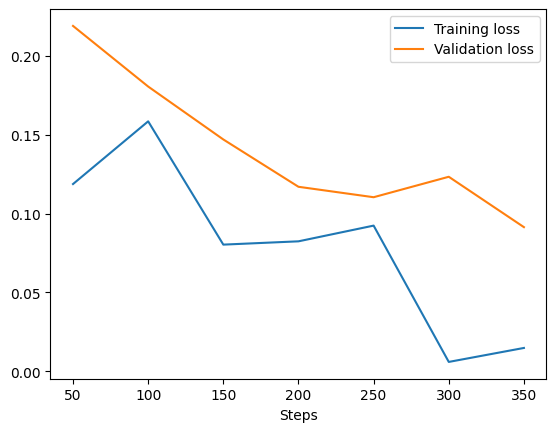

In [635]:
import matplotlib.pyplot as plt
# plot the training losses
x = steps_for_plot
plt.plot(x, train_losses_for_plot , label='Training loss')
plt.plot(x, val_losses_for_plot , label='Validation loss')
plt.xlabel('Steps')
plt.legend()
plt.show()

`0.091375`

Este es el loss de validación más bajo que logré obtener.

## Parte 7: Testing

Veamos cómo le fue:

In [636]:
# get test accuracy
test_losses = [] # track loss
num_correct = 0
# iniciate hidden state
h = net.init_hidden(BATCH_SIZE)
# set network to eval mode
net.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    output, h = net(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    # convert probabilities to classes (0,1)
    pred = torch.round(output.squeeze())  
    # compare label predictions
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
# avg test loss
print("Test loss: {:.6f}".format(np.mean(test_losses)))
# Accuracy de test
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.6f}".format(test_acc))

Test loss: 0.091402
Test accuracy: 0.963196


In [637]:
# waos

`0.091402` en loss de test y un accuracy de **96%**. Nada mal. Parece que el modelo ha sido un éxito.

## Part 8: Inferencia

Solo para cerrar, como los inputs son textos cortos y el ser humano entiende intuitivamente cuándo algo es spam y cuándo no, pongamos el modelo a prueba con datos inventados:

In [640]:
def tokenize_review(test_review):
    test_review = test_review.lower() 
    test_text = ''.join([c for c in test_review if c not in punctuation])
    test_words = test_text.split()
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words])
    return test_ints

def predict(net, test_review, sequence_length=SEQ_LEN):
    net.eval()
    test_ints = tokenize_review(test_review)
    seq_length = sequence_length
    features = pad_features(test_ints, seq_length)
    feature_tensor = torch.from_numpy(features)
    batch_size = feature_tensor.size(0)
    h = net.init_hidden(batch_size)
    if(train_on_gpu):
      feature_tensor = feature_tensor.cuda()
    output, h = net(feature_tensor, h)
    pred = torch.round(output.squeeze())
    print('predicted value before rounding: {:.6f}'.format(output.item()))
    # print custom response based on whether test_review is pos/neg
    if(pred.item()==1):
      print('SPAM!')
    else:
      print('NOT SPAM!')

In [673]:
test_spam_1 = "lonely single moms in your area want to meet you click here"
test_spam_2 = "free money for you just sign up here for free money"
test_spam_3 = "congratulations you won a free trip to the bahamas click here to claim your prize"
test_spam_4 = "you have been selected to receive a free gift card click here to claim your free money"
test_spam_5 = "your computer may be in danger click here to download a fix"
test_spam_6 = "a prince wants to give you money for no reason type your bank account info here for free money"
test_spam_7 = "free cash click here to claim your free cash now"
test_spam_8 = "h hi c can i p please have your credit card n number t the date and the t three numbers on the back? t thanks..."

predict(net, test_spam_1)
predict(net, test_spam_2)
predict(net, test_spam_3)
predict(net, test_spam_4)
predict(net, test_spam_5)
predict(net, test_spam_6)
predict(net, test_spam_7)
predict(net, test_spam_8)



predicted value before rounding: 0.032098
NOT SPAM!
predicted value before rounding: 0.129617
NOT SPAM!
predicted value before rounding: 0.822795
SPAM!
predicted value before rounding: 0.992146
SPAM!
predicted value before rounding: 0.005856
NOT SPAM!
predicted value before rounding: 0.737476
SPAM!
predicted value before rounding: 0.782233
SPAM!
predicted value before rounding: 0.063951
NOT SPAM!


In [674]:
test_not_spam_1 = "hey dude what's up are you coming to the party tonight? call me when you see this, thanks"
test_not_spam_2 = "please PLEASSSSSSSEEEEEE for the love of god tell you you finished the deep learn ing home work"
test_not_spam_3 = "you should love yourself NOW!"
test_not_spam_4 = "hey man, we're going to the movies tonight, wanna come?"
test_not_spam_5 = "did you seriously spend your entire pay check on a n i me figures again? seriously?"
test_not_spam_6 = "stop ignoring me, what are we supposed to do now? you're such a jerk you god damn we e b, how are we gonna make it this month?"
test_not_spam_7 = "you know what? no we're done. we're over unless you stop watching that mo e trash, you don't even look at me anymore"
test_not_spam_8 = "hey man, wanna play league?"

predict(net, test_not_spam_1)
predict(net, test_not_spam_2)
predict(net, test_not_spam_3)
predict(net, test_not_spam_4)
predict(net, test_not_spam_5)
predict(net, test_not_spam_6)
predict(net, test_not_spam_7)
predict(net, test_not_spam_8)

predicted value before rounding: 0.007543
NOT SPAM!
predicted value before rounding: 0.067992
NOT SPAM!
predicted value before rounding: 0.005268
NOT SPAM!
predicted value before rounding: 0.003132
NOT SPAM!
predicted value before rounding: 0.001183
NOT SPAM!
predicted value before rounding: 0.002254
NOT SPAM!
predicted value before rounding: 0.002151
NOT SPAM!
predicted value before rounding: 0.002056
NOT SPAM!


Hmm... parece que el modelo no es tan bueno como pensábamos. O sí?

Hay que recordar que un modelo solo puede llegar a ser tan bueno como la data entregada se lo permite.

Recordemos que, de los 5572 textos que teníamos, solo 746 eran spam. Solo el 13% de la data. Así que primero que nada, es esperable que sea mejor detectando cuando algo ***no*** es spam que cuando algo es spam.

Pero además, tenemos un muestreo bastante chico de "*lo que puede ser llamado spam*". El modelo solo tiene conocimiento de un slice muy chico de lo que se puede considerar como spam, y al parecer terminó siendo un slice demasiado cesgado. No necesariamente es data que representa bien el problema.

A pesar de que se obtuvieron resultados impresionantes, i.e: un accuracy de test del 96%, estos resultados no significan mucho en el gran esquema de las cosas, ya que estas métricas solo son relativas a los datos usados, y no son necesariamente la mejor representación del mundo real, o de lo que podría esperar el usuario.

Hay que tener estas cosas en mente al diseñar modelos de Deep Learning. El verdadero *test* de un modelo es su desempeño en el mundo real.